# 1. 加载数据集

In [18]:
import pandas as pd
import numpy as np
from functools import reduce

PATH = "../Mathematical_Expression_Recognition_train/"

def load_data(path = PATH, filename="train.csv"):
    data = pd.read_csv(path+filename)
    paths = np.array(data["filename"])
    labels = np.array(data["label"])
    max_label_length = reduce(lambda x,y:max(x,y), map(lambda x:len(x), labels))
    return {"all_labels":labels,"train":[paths[:80000],labels[:80000]], "valid":[paths[80000:90000], labels[80000:90000]], "test":[paths[-10000:],labels[-10000:]], "max_label_length":max_label_length}

In [19]:
data = load_data()
X_train_files, y_train = data["train"]
X_valid_files, y_valid = data["valid"]
X_test_files, y_test = data["test"]
max_label_length = data["max_label_length"]

train_len = len(X_train_files)
valid_len = len(X_valid_files)
test_len = len(X_test_files)
print("There are %d trainning image"%train_len)
print("There are %d validation image"%valid_len)
print("There are %d testing image"%test_len)
print("The maximum label length is %d"%max_label_length)

There are 80000 trainning image
There are 10000 validation image
There are 10000 testing image
The maximum label length is 11


# 2. 处理数据

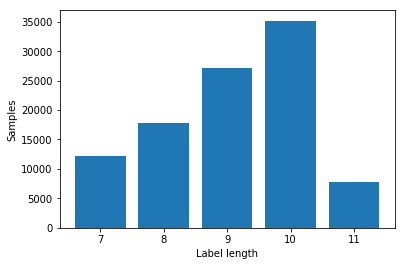

In [20]:
from collections import Counter
labels = data["all_labels"]
labels_length_count = Counter(list(map(lambda x:len(x), labels)))
s = sorted(labels_length_count.items(), key=lambda x:x[0])
name_list = [x[0] for x in s]
num_list = [x[1] for x in s]
plt.bar(range(len(num_list)), num_list, tick_label=name_list)
plt.xlabel("Label length")
plt.ylabel("Samples")
plt.show()

In [21]:
import string
characters = string.digits + "+-*=()"
width, height, n_len, n_class = 170, 32, max_label_length, len(characters)+1

In [22]:
from keras.preprocessing import image                  
from tqdm import tqdm
from functools import reduce
import cv2

def path_to_tensor(img_path):
    # 加载图片向量
    img_path = PATH + img_path
    bgr_img = cv2.imread(img_path)
    img = cv2.resize(bgr_img,(width, height))
    return img

(32, 170, 3)


Text(0.5,1,'label:8+(3-8)=3')

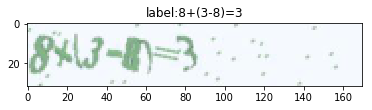

In [23]:
#测试数据和标签是否匹配
import matplotlib.pyplot as plt
%matplotlib inline
img = path_to_tensor(X_test_files[12])
print(img.shape)
plt.imshow(img)
plt.title('label:' + str(y_test[12]))

# 3. 构建模型

In [24]:
from keras import backend as K
#ctc loss 函数
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :] #前两个可以忽略
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [25]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

rnn_size = 128
#定义输入向量
input_tensor = Input((width, height, 3))
x = input_tensor

#构建卷积层，提取图片特征
x = Conv2D(64, (1, 1))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(128, (3, 3), padding="valid", activation='relu')(x)
x = Conv2D(128, (3, 3), padding="valid", activation='relu')(x)
x = Conv2D(128, (3, 3), padding="valid")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

x = Conv2D(256, (3, 3), padding="valid", activation='relu')(x)
x = Conv2D(256, (3, 3), padding="valid", activation='relu')(x)
x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
x = Conv2D(256, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(1, 2), strides=2)(x)

x = Conv2D(512, (3, 3), padding="same", activation='relu')(x)
x = Conv2D(512, (3, 3), padding="same", activation='relu')(x)
x = Conv2D(512, (2, 2), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D(pool_size=(1, 2), strides=1)(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

#两层RNN
x = Bidirectional(GRU(rnn_size, return_sequences=True, name='bi-gru1'))(x)
x = Bidirectional(GRU(rnn_size, return_sequences=True, name='bi-gru2'))(x)

x = Dropout(0.3)(x)
#GRU 输出接入CTC 并计算loss
x = Dense(n_class, activation='softmax')(x)
base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(1e-4))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 170, 32, 3)    0                                            
____________________________________________________________________________________________________
conv2d_12 (Conv2D)               (None, 170, 32, 64)   256         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, 170, 32, 64)   256         conv2d_12[0][0]                  
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 170, 32, 64)   0           batch_normalization_5[0][0]      
___________________________________________________________________________________________

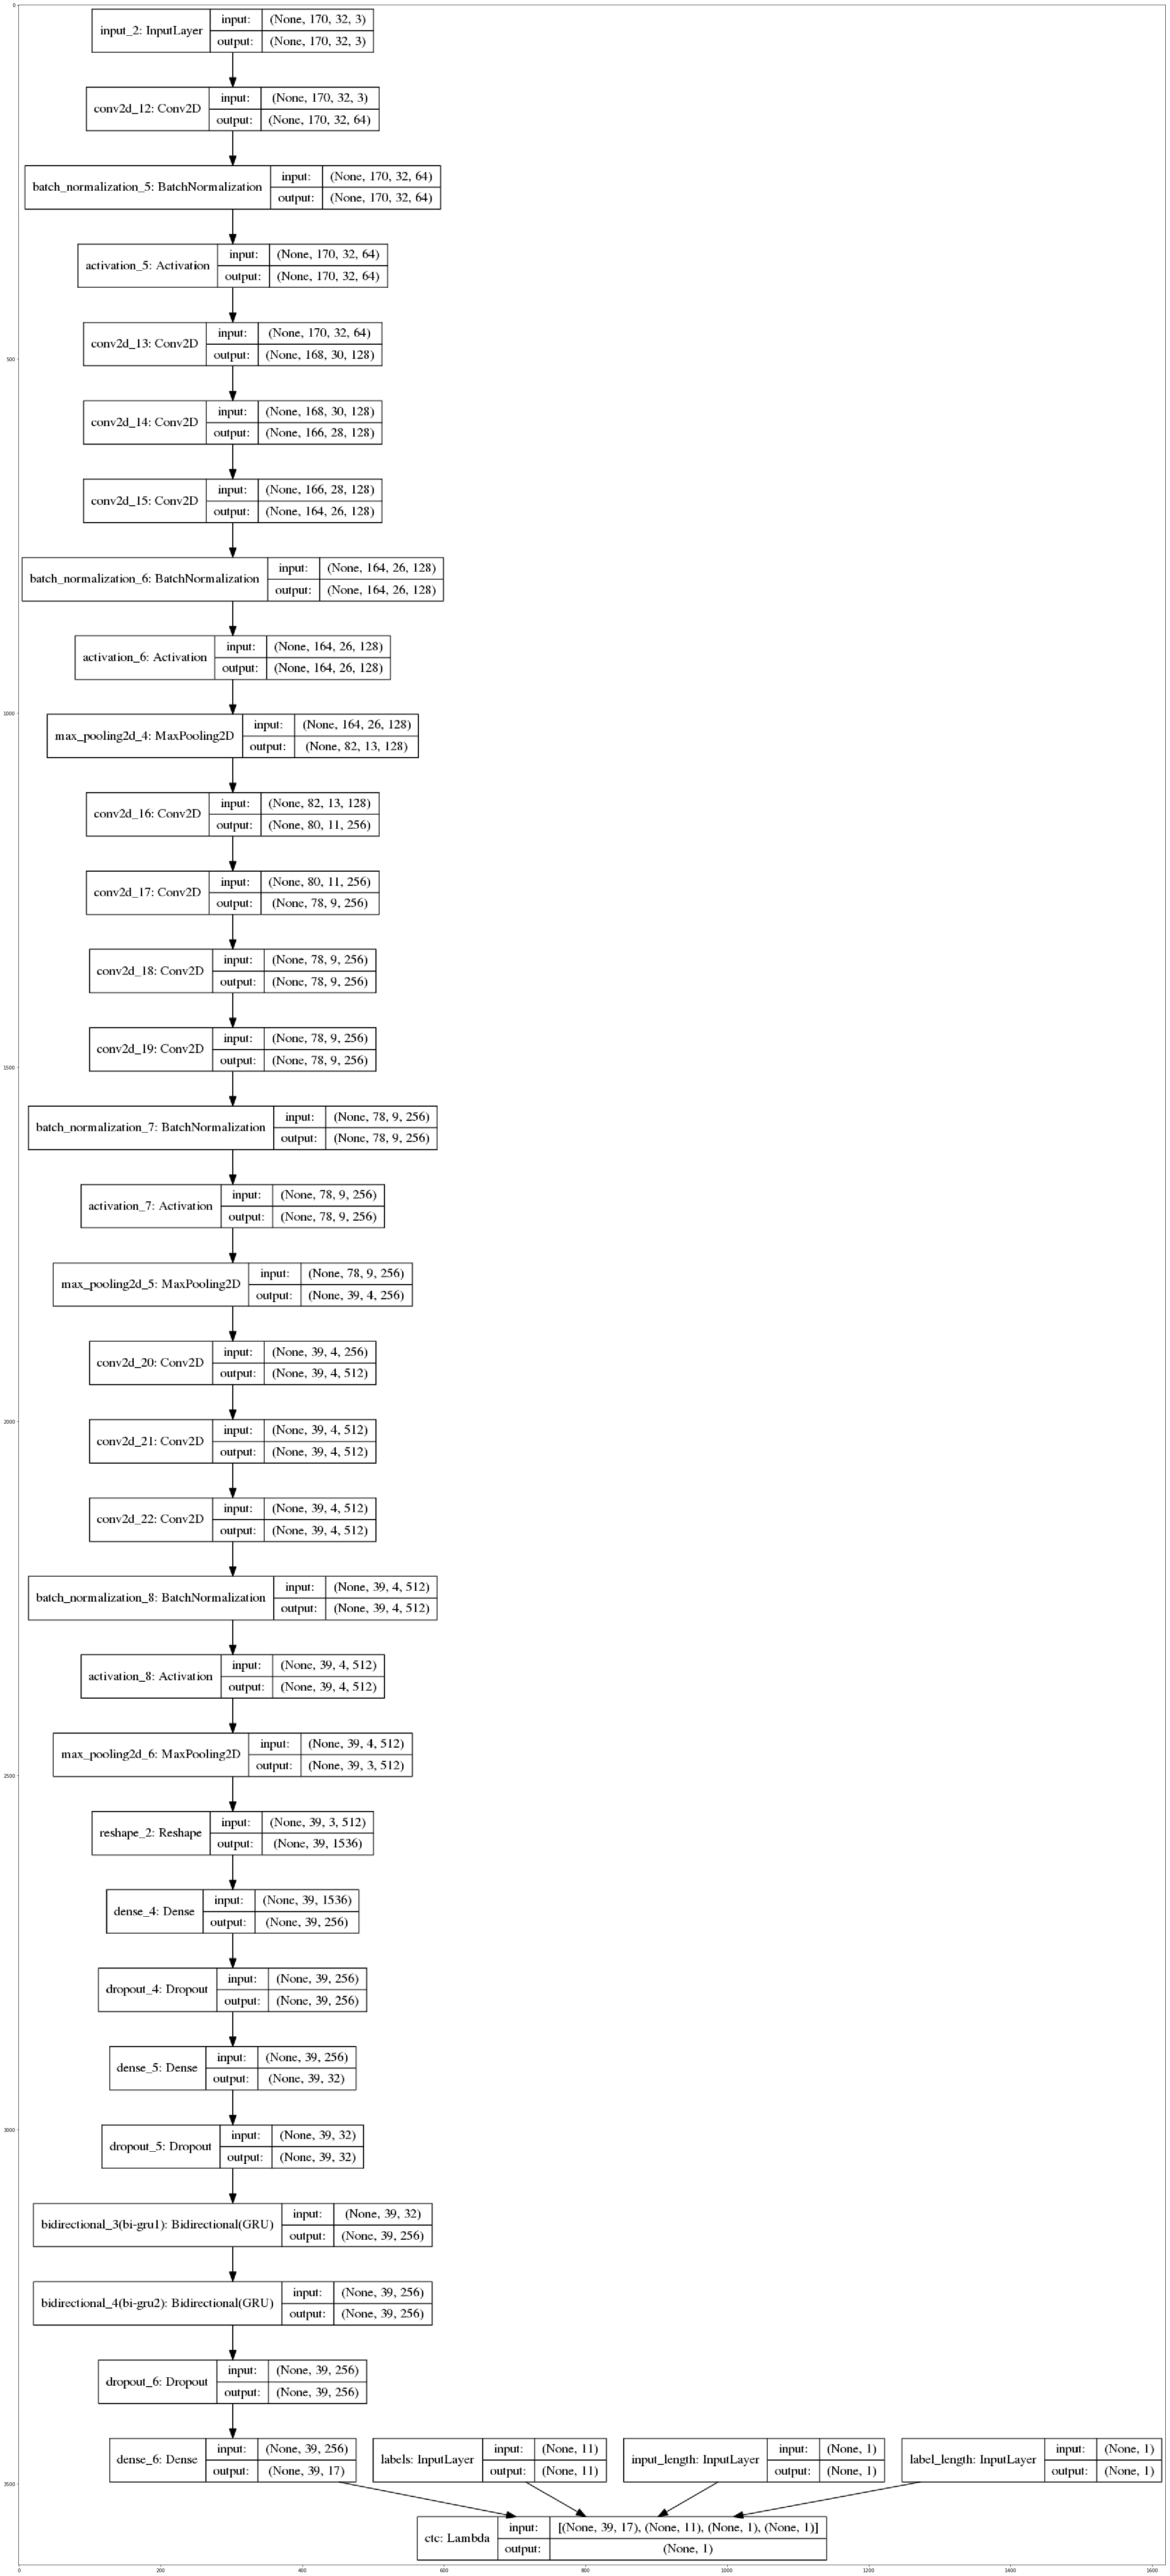

In [26]:
#可视化模型结构
from keras.utils.vis_utils import plot_model
import pydot
plot_model(model, to_file="model.png", show_shapes=True)

import cv2
img = cv2.imread("model.png")
small_img = img.astype("float32")/255
plt.figure(figsize = (50,100))
plt.imshow(small_img)

# 4. 数据生成器

In [27]:
from keras.preprocessing.sequence import *
from random import *
def generator_batch(bz=256, data_type="tr"):
    X = np.zeros((bz, width, height, 3), dtype=np.uint8)
    y = np.zeros((bz, n_len), dtype=np.int32)
    label_length = np.ones(bz)
    global counter
    while True:
        for i in range(bz): 
            if data_type == "tr": #从训练集中随机选择一个样本
                counter = randint(0,train_len - 1)
                data_set = X_train_files
                labels = y_train
            elif data_type == "va": #从验证集中随机选择一个样本
                counter = randint(0, valid_len - 1)
                data_set = X_valid_files
                labels = y_valid
            elif data_type == "te": #从测试集中随机选择一个样本
                counter = randint(0, test_len - 1)
                data_set = X_test_files
                labels = y_test
                
            X[i] = path_to_tensor(data_set[counter]).transpose(1,0,2)
            length = len(labels[counter])
            y[i,:length] = [characters.find(x) for x in labels[counter]]
            y[i,length:] = (n_class - 1) #不足长度的用 n_class - 1 补足。
            label_length[i] = length #序列的长度
            
        yield [X, y, np.ones(bz)*int(conv_shape[1] - 2), label_length], np.ones(bz)

[[ 3 11 14  9 11  1 15 13 11  5 16]
 [ 4 12 14  6 12  0 15 13  0 16 16]
 [14  7 10  8 15 11  7 13  8 16 16]
 [ 2 12 14  9 10  1 15 13  2  0 16]
 [ 4 11  3 11  0 13  1 16 16 16 16]
 [ 1 12 14  4 11  7 15 13 11  3 16]
 [ 6 11 14  0 10  8 15 13 11  2 16]
 [ 3 11 14  8 10  4 15 13 11  9 16]
 [14  3 11  7 15 11  5 13 11  9 16]
 [ 0 12  0 12  7 13  0 16 16 16 16]]


Text(0.5,1,'label:3-(9-1)=-5')

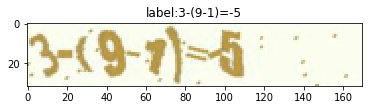

In [28]:
#测试生成器
gen = generator_batch(bz=10, data_type="va")
[X_test, y, input_length, label_length], label = next(gen)
print(y)
plt.imshow(X_test[0].transpose(1,0,2))
y_true = ''.join([characters[x] for x in y[0] if x < len(characters)])
plt.title('label:' + str(y_true))

# 5. 自定义history

In [29]:
#定义评估函数
def evaluate(model, gen = generator_batch(data_type="va"), batch_num=10):
    batch_acc = 0
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(gen)
        y_pred = model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:,:n_len]
        out[out == -1] = (n_class - 1)
        if out.shape[1] == n_len:
            batch_acc += (y_test == out).all(axis=-1).mean()
    return batch_acc / batch_num

In [31]:
from keras.callbacks import *

#自定义history callback
class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.val_loss = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        acc = evaluate(base_model) * 100
        self.val_acc.append(acc)
        print("val_acc: {:.2f}%".format(acc))
    
    def on_train_end(self, logs={}):
        test_acc = evaluate(base_model, gen=generator_batch(data_type="te"), batch_num=50)
        print("The accuracy on test set: {:.2f}".format(test_acc * 100))
        
history = History()

# 6. 训练模型

In [13]:
#保存best weights
checkpointer =ModelCheckpoint(filepath="./best_weights/cudnngru-net-epoch.hdf5", verbose=2, save_best_only=True)  

reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, mode="auto", factor=0.1, patience=5, min_lr=(1e-10))


batch_size = 128
epochs = 50

model.fit_generator(generator_batch(bz=batch_size, data_type="tr"), steps_per_epoch=51200//batch_size, epochs=epochs,
                    callbacks=[reduce_lr, history, checkpointer],verbose=2,
                    validation_data=generator_batch(bz=batch_size, data_type="va"), 
                    validation_steps=1280//batch_size)

Epoch 1/50
 - 493s - loss: 19.7526 - val_loss: 11.0424
val_acc: 1.45%

Epoch 00001: val_loss improved from inf to 11.04240, saving model to ./best_weights/cudnngru-net-epoch.hdf5
Epoch 2/50
 - 482s - loss: 5.8124 - val_loss: 5.1622
val_acc: 60.74%

Epoch 00002: val_loss improved from 11.04240 to 5.16216, saving model to ./best_weights/cudnngru-net-epoch.hdf5
Epoch 3/50
 - 482s - loss: 2.9744 - val_loss: 3.1345
val_acc: 75.08%

Epoch 00003: val_loss improved from 5.16216 to 3.13452, saving model to ./best_weights/cudnngru-net-epoch.hdf5
Epoch 4/50
 - 482s - loss: 2.3056 - val_loss: 2.6817
val_acc: 79.77%

Epoch 00004: val_loss improved from 3.13452 to 2.68166, saving model to ./best_weights/cudnngru-net-epoch.hdf5
Epoch 5/50
 - 482s - loss: 2.1755 - val_loss: 2.1293
val_acc: 86.02%

Epoch 00005: val_loss improved from 2.68166 to 2.12929, saving model to ./best_weights/cudnngru-net-epoch.hdf5
Epoch 6/50
 - 481s - loss: 1.7154 - val_loss: 4.5653
val_acc: 89.73%

Epoch 00006: val_loss did 

In [36]:
model.load_weights('./cudnngru2-net-epoch.hdf5')

# 7. 可视化history

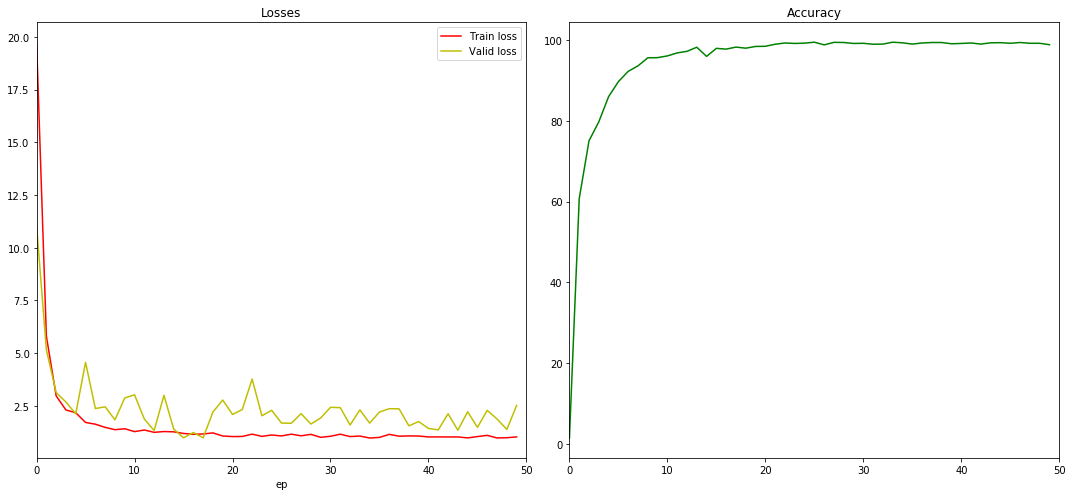

In [14]:
iters = range(epochs)

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1, 2, 1)
ax.plot(iters, history.train_loss, color="r", label = "Train loss")
ax.plot(iters, history.val_loss, color="y", label="Valid loss")
ax.legend()
ax.set_xlim(0, 50)
ax.set_title("Losses")
ax.set_xlabel("ep")

ax = fig.add_subplot(1, 2, 2)
ax.plot(iters, history.val_acc, color="g", label = "Valid accuracy")
ax.set_xlim(0, 50)
ax.set_title("Accuracy")

fig.tight_layout()
plt.show()

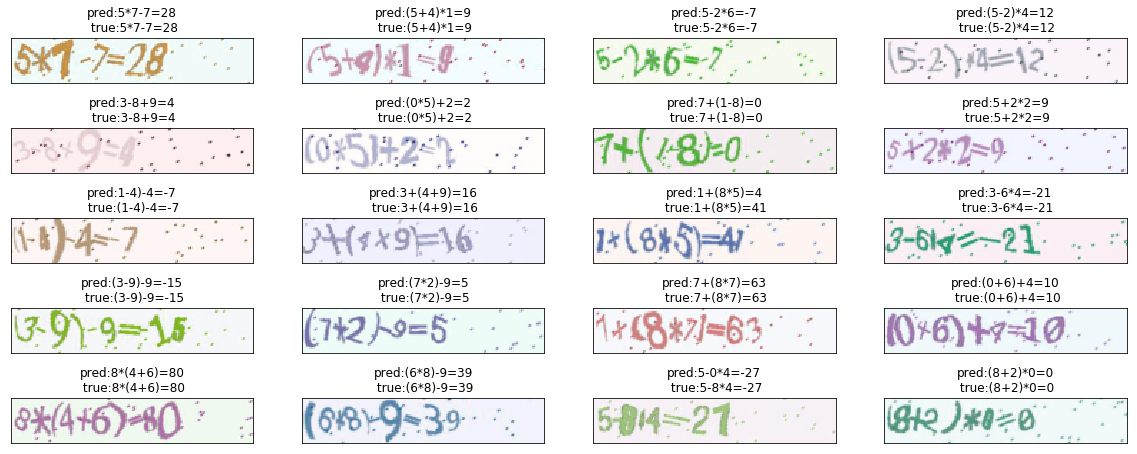

In [64]:
#展示25张图片
gen_pred=generator_batch(bz=10000, data_type="te")
[X_test, y_true, _, _], _  = next(gen_pred)

y_tmp = base_model.predict(X_test)
shape = y_tmp[:,2:,:].shape
y_pred = K.get_value(K.ctc_decode(y_tmp[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:,:n_len]
y_pred[y_pred == -1] = (n_class - 1)

plt.figure(figsize=(20,8))
for i in range(20):
    plt.subplot(5, 4, i + 1,xticks=[], yticks=[])
    y_true_labels = ''.join([characters[x] for x in y_true[i] if x < len(characters)])
    y_pred_labels = ''.join([characters[x] for x in y_pred[i] if x < len(characters)])
    plt.imshow(X_test[i].transpose(1,0,2)/255)
    plt.title('pred:%s\n true:%s'%(str(y_pred_labels), str(y_true_labels)))

Text(0.5,69,'Predicted')

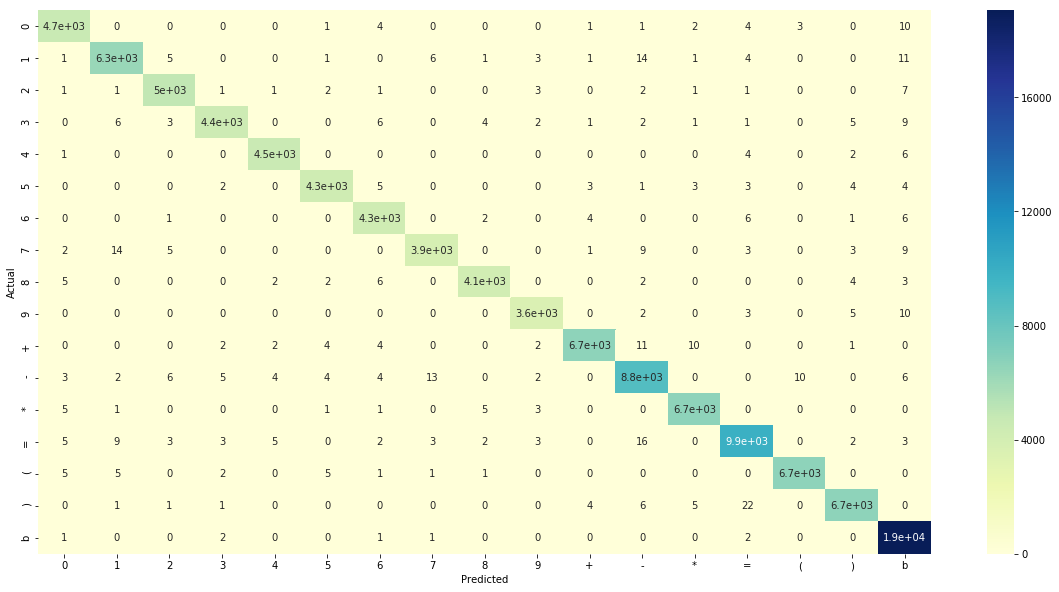

In [69]:
#混淆矩阵
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))

cm = confusion_matrix(y_true.flatten(), y_pred.flatten())

xticklabels = characters + "b"
yticklabels = characters + "b"
ax = sns.heatmap(cm,annot=True, cmap="YlGnBu")
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")